# Домашнее задание №2


Перед вами датасет с данными о вреде курения


Структура данных:

1. **gender**: Пол пациента
2. **age**: Возраст пациента
3. **hypertension**: Наличие гипертонии у пациента 1 - есть, 0 - не наблюдалось
4. **heart_disease**: Наличие у пациента болезней связанных с сердцем 1 - есть, 0 - здоров
5. **ever_married**: Брак - (Состоял в браке/ холост)
6. **work_type**: Работ - Ребенок(children), Госслужащий(Govt_jov), Никогда не работал(Never_worked), Самозанятый(self-employed) или Скрыто(private)
7. **Residence_type**: место работы городская среда(Urban)/удаленка или за городом(Rural)
8. **avg_glucose_level**: средний уровень глюкозы в крови
9. **bmi**: индекс массы тела
10. **smoking_status**: Пациент курит(Иногда, всегда, время от времени или Unknown - неизвестно)
11. **stroke**: Перенесенный инсульт (1 - пациент перенес инсульт, 0 - инсульта не было) - *ваш target*

## Ваша задача

№1 Восстановить целостностью данных, реализовать функцию позволяющие выполнять заполнение данных по среднему или по медианному значению в Series. 

1.  Заполнить пропуски
2.  Убрать дубликаты
3.  Убрать некорректные данные и.т.п.


№2 Построить baseline-модель, попытаться выбить лучший скор (сравнить несколько моделей)

№3 Сделать визуализацию для мини-исследования о вреде курения с разбивкой по половой принадлежности пациентов с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [136]:
url = 'https://drive.google.com/file/d/1He5GI5_Gd8uXYfeETLBISQ5BszX0o4pU/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, names=['index','gender', 'age', 'hypertension', 'heart_disease',
       'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level',
       'bmi', 'smoking_status', 'stroke'])
data = data.drop('index', axis=1)

In [137]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,67.0,0.0,1.0,Yes,Private,Urban,228.69,NaN,formerly smoked,1
3,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
4,Male,80.0,0.0,1.0,Yes,Private,NaN,105.92,32.5,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5107,Female,80.0,1.0,0.0,Yes,Private,Urban,83.75,NaN,never smoked,0
5108,Female,81.0,0.0,0.0,Yes,Self-employed,Urban,125.2,40.0,never smoked,0
5109,Female,35.0,0.0,0.0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5110,Male,51.0,0.0,0.0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [138]:
df = data.drop(index=[0,1])

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 2 to 5111
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             5110 non-null   object
 1   age                4967 non-null   object
 2   hypertension       4907 non-null   object
 3   heart_disease      4282 non-null   object
 4   ever_married       5110 non-null   object
 5   work_type          4775 non-null   object
 6   Residence_type     4306 non-null   object
 7   avg_glucose_level  4622 non-null   object
 8   bmi                4167 non-null   object
 9   smoking_status     5110 non-null   object
 10  stroke             5110 non-null   object
dtypes: object(11)
memory usage: 439.3+ KB


In [140]:
df = df.drop_duplicates(keep='first')

In [141]:
df.stroke.value_counts()

0    4857
1     249
Name: stroke, dtype: int64

In [142]:
df.loc[df.work_type !='children'].stroke.value_counts()

0    4230
1     247
Name: stroke, dtype: int64

Из всех наблюдений по больным, всего 2 из них о детях, при этом всего детей 629. Организмы детей сильно отличаются от взрослых и зачастую требуют отдельных исследований, поэтому и стоит рассматривать эти две возрастные группы отдельно. На основании 2х случаев из 629 по детям, невозможно сделать достоверное исследование. Поэтому считаю целесообразным удалить наблюдения о детях и всю дальнейшую работу осуществлять только со взрослыми.

In [143]:
df.loc[(df.work_type =='children') & (df.stroke == '1')]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
164,Female,1.32,0.0,0.0,No,children,Urban,70.37,NaN,Unknown,1
247,Female,14.0,0.0,NaN,No,children,Rural,57.93,30.9,Unknown,1


In [144]:
df = df.loc[df.work_type !='children'].reset_index(drop=True)

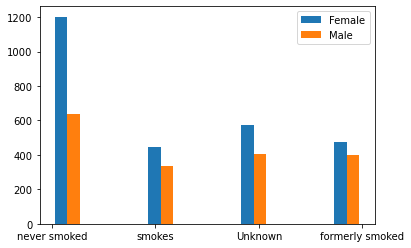

In [145]:
x1 = df[df['gender'] == 'Female']['smoking_status']
x2 = df[df['gender'] == 'Male']['smoking_status']
plt.hist([x1, x2])
plt.legend(('Female', 'Male'))
plt.show()

In [146]:
df.gender.value_counts()

Female    2693
Male      1783
Other        1
Name: gender, dtype: int64

Наблюдений по людям женского пола больше в 1.5 раза, но при этом никогда не курящих женщин больше в 2 раза, чем мужчин. По неизвестным первоначальное отношение сохраняется. То есть процент мужчин курящих или ранее курящих по отношению к общему количеству больше, чем женщин.

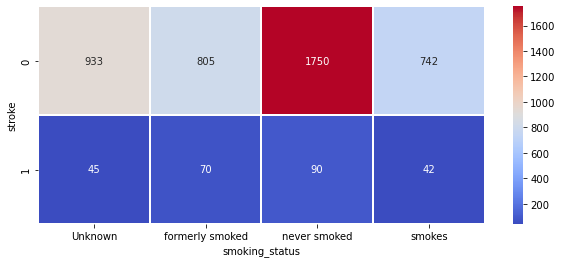

In [147]:
plt.subplots(figsize=(10, 4))
sns.heatmap(pd.crosstab(df['stroke'], df['smoking_status']), cmap='coolwarm', linewidths=.1, fmt="d", annot=True)
plt.show()

Дозаполним данные по медианным значениям для числовых признаков и модой для категориальных.

In [148]:
df.age = df.age.astype('float')
df.avg_glucose_level = df.avg_glucose_level.astype('float')
df.bmi = df.bmi.astype('float')

In [150]:
def my_fill_nan(df):
    for i in df.columns:
        if df[i].dtype == 'float64':
            df[i] = df[i].fillna(df[i].median())
        else:
            df[i] = df[i].fillna(df[i].mode()[0])
    return df

In [151]:
df = my_fill_nan(df)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4477 entries, 0 to 4476
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4477 non-null   object 
 1   age                4477 non-null   float64
 2   hypertension       4477 non-null   object 
 3   heart_disease      4477 non-null   object 
 4   ever_married       4477 non-null   object 
 5   work_type          4477 non-null   object 
 6   Residence_type     4477 non-null   object 
 7   avg_glucose_level  4477 non-null   float64
 8   bmi                4477 non-null   float64
 9   smoking_status     4477 non-null   object 
 10  stroke             4477 non-null   object 
dtypes: float64(3), object(8)
memory usage: 384.9+ KB


In [153]:
scaler = StandardScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

In [154]:
encoder = OrdinalEncoder()
columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']
df[columns] = pd.DataFrame(encoder.fit_transform(df[columns]), columns=columns)

In [155]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,0.985527,0.0,1.0,1.0,2.0,1.0,2.728212,-0.148704,1.0,1.0
1,0.0,0.668282,0.0,0.0,1.0,3.0,0.0,2.138672,-0.148704,2.0,1.0
2,1.0,1.672892,0.0,1.0,1.0,2.0,1.0,-0.005092,0.371531,2.0,1.0
3,0.0,0.033791,0.0,0.0,1.0,2.0,1.0,1.448945,0.662250,3.0,1.0
4,0.0,1.620018,1.0,0.0,1.0,3.0,0.0,1.513287,-0.929056,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4472,0.0,1.672892,1.0,0.0,1.0,2.0,1.0,-0.498676,-0.148704,2.0,0.0
4473,0.0,1.725766,0.0,0.0,1.0,3.0,1.0,0.424151,1.519107,2.0,0.0
4474,0.0,-0.706448,0.0,0.0,1.0,3.0,0.0,-0.515596,0.080811,2.0,0.0
4475,1.0,0.139540,0.0,0.0,1.0,2.0,0.0,1.338963,-0.684239,1.0,0.0


In [156]:
undersample = NearMiss(version=2)
X = df.drop('stroke', axis=1)
y = df.stroke
X, y = undersample.fit_resample(X, y)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86        51
         1.0       0.94      0.71      0.81        48

    accuracy                           0.84        99
   macro avg       0.86      0.83      0.83        99
weighted avg       0.86      0.84      0.84        99



In [194]:
grid_searcher = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': range(25, 301, 25),
                                                                   'max_features': ['log2', 'sqrt'],
                                                                   'max_depth': range(5, 14, 1)
                                                                  })
grid_searcher.fit(X_train, y_train)
y_pred_grid = grid_searcher.predict(X_test)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86        51
         1.0       0.90      0.77      0.83        48

    accuracy                           0.85        99
   macro avg       0.86      0.85      0.85        99
weighted avg       0.85      0.85      0.85        99



In [289]:
XGb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
XGb.fit(X_train, y_train)
y_pred = XGb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86        51
         1.0       0.92      0.73      0.81        48

    accuracy                           0.84        99
   macro avg       0.85      0.84      0.84        99
weighted avg       0.85      0.84      0.84        99



In [202]:
grid_searcher = GridSearchCV(XGBClassifier(), param_grid={'use_label_encoder': [False],
                                                          'eval_metric': ['logloss'],
                                                          'n_estimators': range(10, 301, 5),
                                                          'max_depth': range(5, 15, 1)
                                                         })
grid_searcher.fit(X_train, y_train)
y_pred_grid = grid_searcher.predict(X_test)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85        51
         1.0       0.94      0.69      0.80        48

    accuracy                           0.83        99
   macro avg       0.85      0.82      0.82        99
weighted avg       0.85      0.83      0.82        99



In [245]:
clf = CatBoostClassifier()
clf.fit(X_train, y_train, verbose=False)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88        51
         1.0       0.95      0.75      0.84        48

    accuracy                           0.86        99
   macro avg       0.88      0.86      0.86        99
weighted avg       0.87      0.86      0.86        99



In [284]:
column = ['hypertension', 'bmi'] # подобрано методом удаления по одному столбцу до улучшения показателей метрик
X_train2, X_test2 = X_train.drop(column, axis=1), X_test.drop(column, axis=1)
clf = CatBoostClassifier()
clf.fit(X_train2, y_train, verbose=False)
y_pred = clf.predict(X_test2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        51
         1.0       0.95      0.79      0.86        48

    accuracy                           0.88        99
   macro avg       0.89      0.88      0.88        99
weighted avg       0.89      0.88      0.88        99

